# Сравнение поисковых деревьев
### Выполнили Вихрев И., Репин В. гр 382006-3м

In [10]:
import sys
import os
from pathlib import Path
import numpy as np
import random
import time
import statistics as stat
sys.path.append(str(Path.cwd().resolve()/'python_bindings'))
import trees

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style = 'whitegrid', rc={'figure.figsize':(20, 10)})

In [12]:
dir(trees)

['AVLTreeInt',
 'AVLTreeString',
 'RBTreeInt',
 'RBTreeString',
 'SortedArrInt',
 'SortedArrString',
 'SplayTreeInt',
 'SplayTreeString',
 'TreapInt',
 'TreapString',
 '__builtins__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__test__']

In [13]:
def evaluate(tree, unique_set, count_rot = False):
    total = 0
    insert_time = []
    search_time = []
    delete_time = []
    rotations_count = []
    
    shuffled_set = random.sample(unique_set, len(unique_set))
    # insertion and searching time
    start_total = time.time()
    for idx, n in enumerate(unique_set):
        insert_mean = 0
        delete_mean = 0
        search_mean = 0
        #print('-'*40, idx , '-'*40)
        #print('Insert ', n)
        #insert_mean += tree.insert(n) /2
        #delete_mean += tree.delete(n)
        #insert_mean += tree.insert(n) /2
        tree.insert(n)
        if (idx == 0): continue
        
        # make 5 operations for random element from already added numbers
        for i in range(5):
            el = random.randrange(idx)
#             print("Del" , unique_set[el])
            delete_mean += tree.delete(unique_set[el]) / 5
            insert_mean += tree.insert(unique_set[el]) / 5
            search_mean += tree.search(unique_set[random.randrange(idx)]) / 5
        
        insert_time.append(insert_mean)
        delete_time.append(delete_mean)
        search_time.append(search_mean)     
        
        if(count_rot):
            rotations_count.append(tree.rotations_num)
        
    end_total = time.time()
    total = end_total - start_total
    
    insert_mean = stat.mean(insert_time)
    std_insert = stat.stdev(insert_time)
    
    search_mean = stat.mean(search_time)
    std_search = stat.stdev(search_time)
    
    delete_mean = stat.mean(delete_time)
    std_delete = stat.stdev(delete_time)
    
    print(f'Insert, Mean : {stat.mean(insert_time)*10**(3):.6f} ms.,  Max {max(insert_time)*10**(3):.6f} ms.')
    print(f'Search, Mean : {stat.mean(search_time)*10**(3):.6f} ms.,  Max {max(search_time)*10**(3):.6f} ms.')
    print(f'Delete, Mean : {stat.mean(delete_time)*10**(3):.6f} ms.,  Max {max(delete_time)*10**(3):.6f} ms.')
    
    insert_time = [x if x < insert_mean + 3*std_insert else insert_mean for x in insert_time]
    search_time = [x if x < search_mean + 3*std_search else search_mean for x in search_time]
    delete_time = [x if x < delete_mean + 3*std_delete else delete_mean for x in delete_time]
    
    print(f'Total time {(total):.6f}, sec')
    return (insert_time, search_time, delete_time, rotations_count)

Гененеруем выборку уникальных натуральных чисел:

In [31]:
r = 10**7
unique_num_set = random.sample(range(0, r), r)
num = range(1, len(unique_num_set))

Выбираем контрольные значения для оси X

In [32]:
d = 10**4
x = [i*d for i in range(len(unique_num_set)//d)]
x[-1] += -1

### Методика: 
Замер времени вставки, поиска и удаления элемента проводился 5 раз для каждого количества элементов дерева. В результат бралось среднее значение 5 измерений для каждой операции на каждой итерации цикла. График зависимости строим по данным для каждого 1000 элемента. Выборка обрабатывается по правилу трех сигм.

* np.polyfit(np.log2(num), *, 1) - неустойчивый метод, может при некоторых запусках не сходится, требуется перезапуск

# splay tree

Двоичное дерево поиска, в котором поддерживается свойство сбалансированности. Особенностью является то, что при каждом обращении к дереву вызывается функция splay(x) - перемещение элемента x к корню дерева. Амортизированное время выполнения основных операций(вставка, поиск, удаление) - O(log(n))

In [37]:
insert_time, search_time, delete_time, _ = evaluate(trees.SplayTreeInt(), unique_num_set)

Insert, Mean : 0.000473 ms.,  Max 0.664220 ms.
Search, Mean : 0.002758 ms.,  Max 2.020100 ms.
Delete, Mean : 0.003323 ms.,  Max 3.254440 ms.
Total time 533.460046, sec


### Insertion

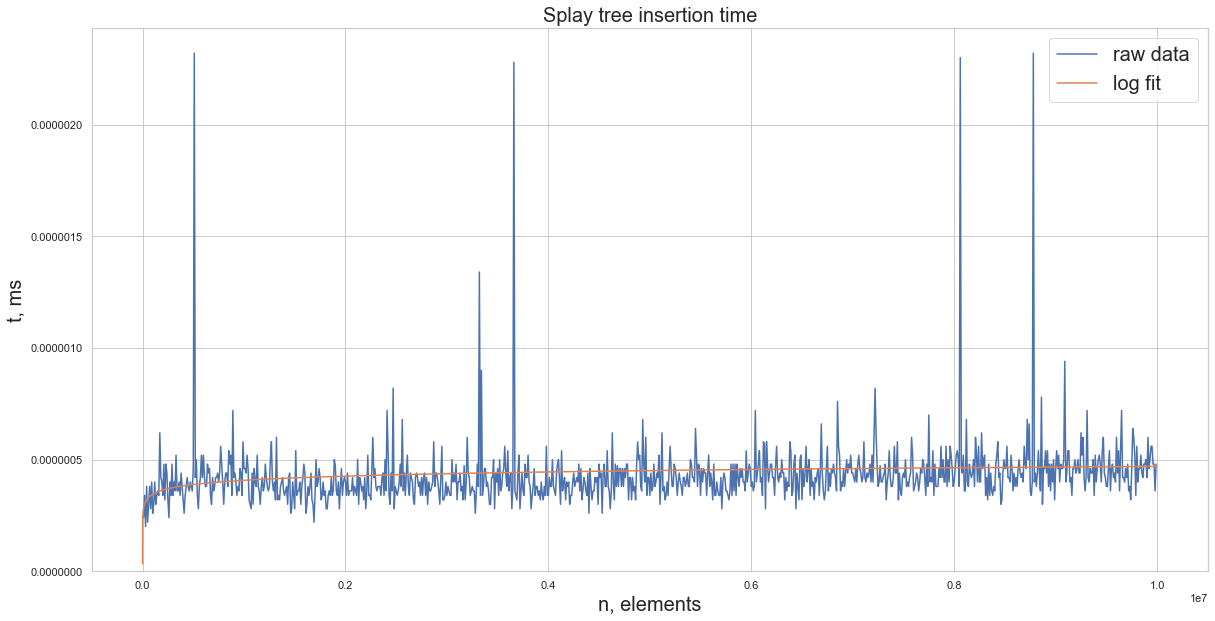

In [38]:
y = [insert_time[el] for el in x]

plt.title("Splay tree insertion time", fontsize=20)
plt.xlabel('n, elements', fontsize=20)
plt.ylabel('t, ms', fontsize=20)
plt.plot(x, y) 

# Least Squares log Regression
coeff = np.polyfit(np.log2(num), insert_time, 1)
log_y = [np.log2(n)*coeff[0] + coeff[1] for n in num]
plt.plot(num, log_y)  
plt.legend(['raw data', 'log fit'], fontsize=20)
plt.ylim(bottom=0.)
pass

### Searching

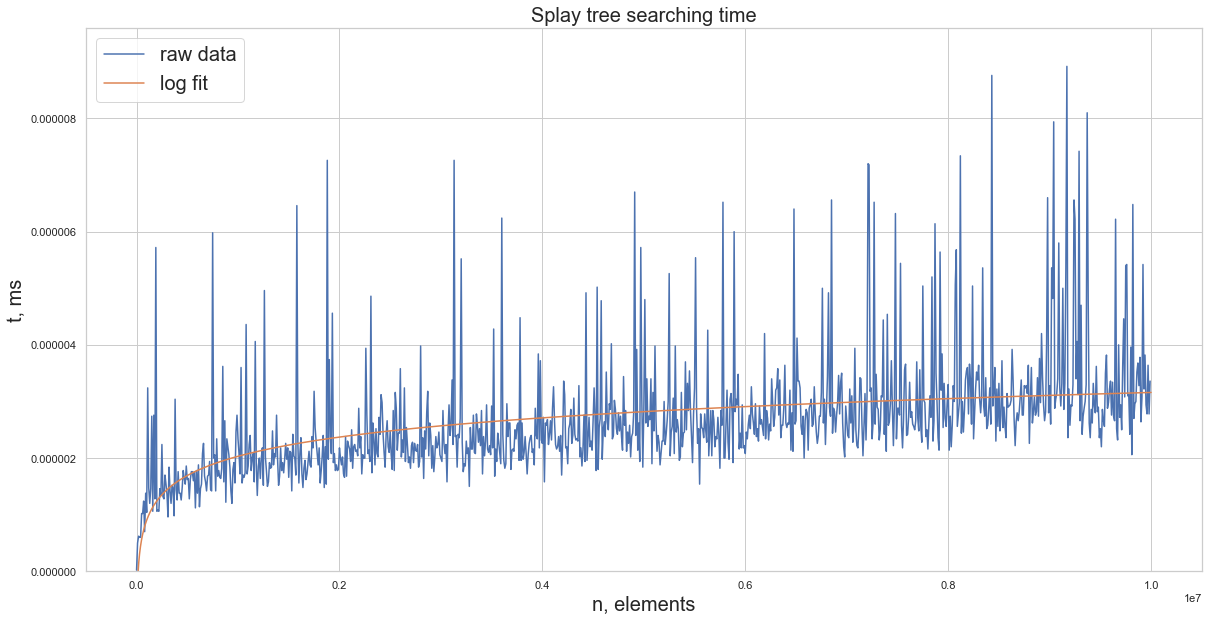

In [40]:
y = [search_time[el] for el in x]

plt.title("Splay tree searching time", fontsize=20)
plt.xlabel('n, elements', fontsize=20)
plt.ylabel('t, ms', fontsize=20)
plt.plot(x, y)

# Least Squares log Regression
coeff = np.polyfit(np.log2(num), search_time, 1)
log_y = [np.log2(n)*coeff[0] + coeff[1] for n in num]
plt.plot(num, log_y)  
plt.legend(['raw data', 'log fit'], fontsize=20)
plt.ylim(bottom=0.)
pass

### Deletion

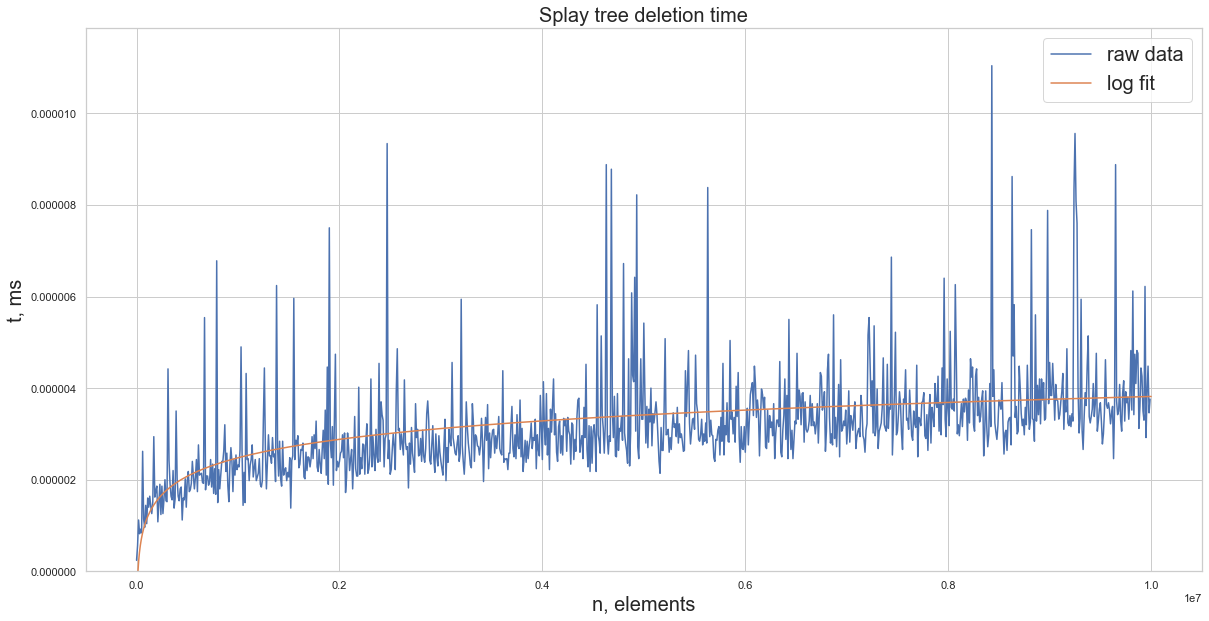

In [42]:
y = [delete_time[el] for el in x]

plt.title("Splay tree deletion time", fontsize=20)
plt.xlabel('n, elements', fontsize=20)
plt.ylabel('t, ms', fontsize=20)
plt.plot(x, y)

# Least Squares log Regression
coeff = np.polyfit(np.log2(num), delete_time, 1)
log_y = [np.log2(n)*coeff[0] + coeff[1] for n in num]
plt.plot(num, log_y)
plt.legend(['raw data', 'log fit'], fontsize=20)
plt.ylim(bottom=0.)
pass

# AVL tree

Сбалансированное двоичное дерево поиска, в котором поддерживается следующее свойство: для каждой его вершины высота её двух поддеревьев различается не более чем на 1. Среднее время выполнения основных операций O(log(n))

In [43]:
insert_time, search_time, delete_time, rotations_count = evaluate(trees.AVLTreeInt(), unique_num_set, True)

Insert, Mean : 0.000847 ms.,  Max 10.756660 ms.
Search, Mean : 0.001758 ms.,  Max 2.110900 ms.
Delete, Mean : 0.003514 ms.,  Max 3.616740 ms.
Total time 525.889808, sec


### Rotations

Количество поворотов при вставке:

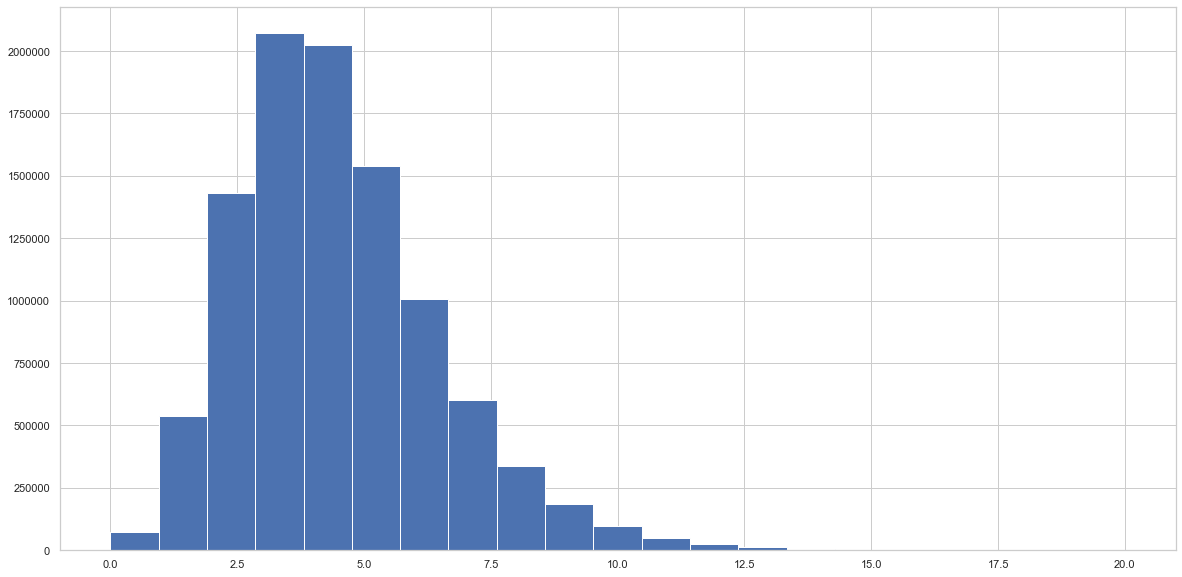

In [44]:
plt.hist(rotations_count, bins = len(set(rotations_count)) )
pass


Максимальное количество поворотов, выполненных при вставке для балансировки дерева:

In [45]:
max(rotations_count)

20

### Insertion

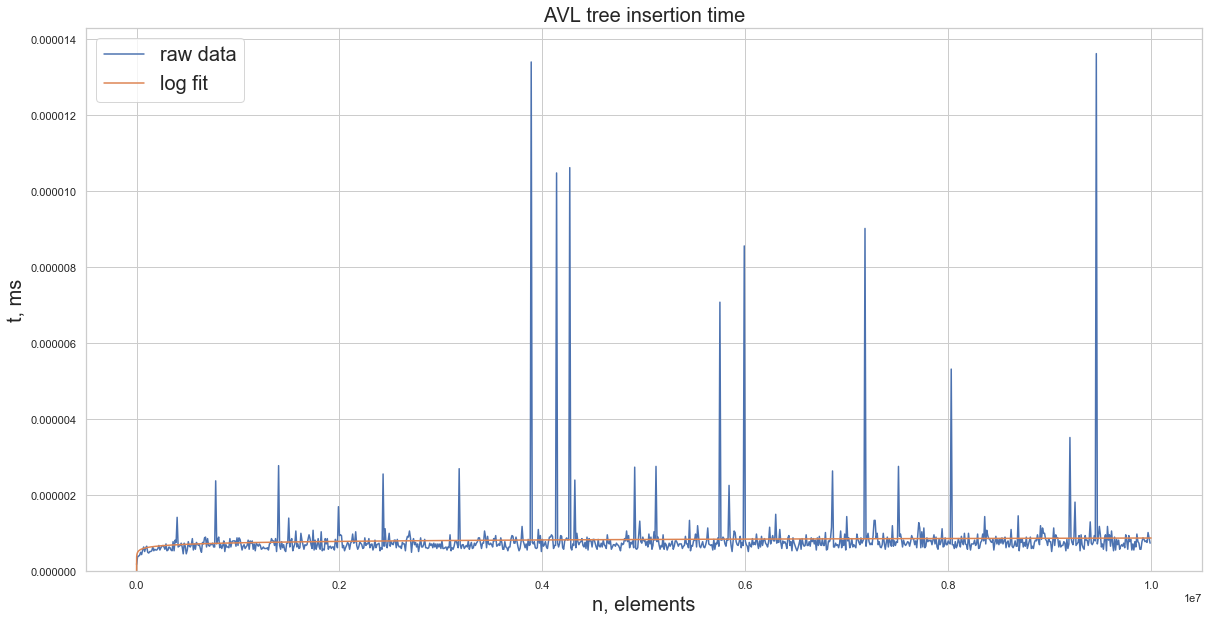

In [47]:
y = [insert_time[el] for el in x]

plt.title("AVL tree insertion time", fontsize=20)
plt.xlabel('n, elements', fontsize=20)
plt.ylabel('t, ms', fontsize=20)
plt.plot(x, y)

# Least Squares log Regression
coeff = np.polyfit(np.log2(num), insert_time, 1)
log_y = [np.log2(n)*coeff[0] + coeff[1] for n in num]
plt.plot(num, log_y)  
plt.legend(['raw data', 'log fit'], fontsize=20)
plt.ylim(bottom=0.)
pass

### Searching

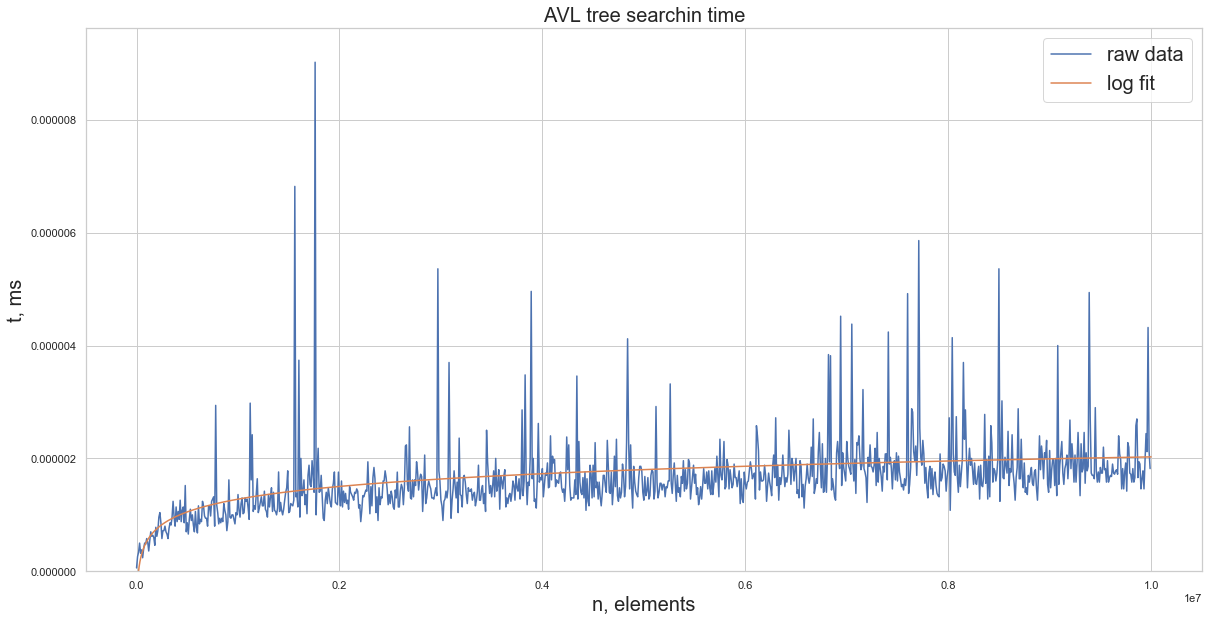

In [49]:
y = [search_time[el] for el in x]

plt.title("AVL tree searchin time", fontsize=20)
plt.xlabel('n, elements', fontsize=20)
plt.ylabel('t, ms', fontsize=20)
plt.plot(x, y)

# Least Squares log Regression
coeff = np.polyfit(np.log2(num), search_time, 1)
log_y = [np.log2(n)*coeff[0] + coeff[1] for n in num]
plt.plot(num, log_y)  
plt.legend(['raw data', 'log fit'], fontsize=20)
plt.ylim(bottom=0.)
pass

### Deletion

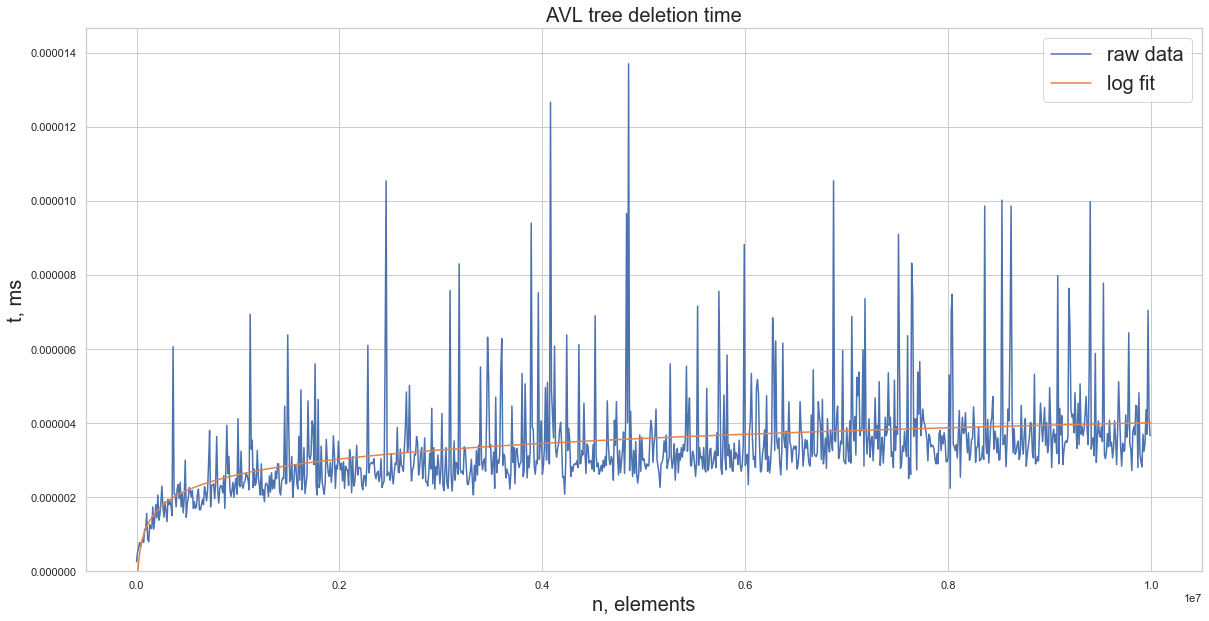

In [51]:
y = [delete_time[el] for el in x]

plt.title("AVL tree deletion time", fontsize=20)
plt.xlabel('n, elements', fontsize=20)
plt.ylabel('t, ms', fontsize=20)
plt.plot(x, y)

# Least Squares log Regression
coeff = np.polyfit(np.log2(num), delete_time, 1)
log_y = [np.log2(n)*coeff[0] + coeff[1] for n in num]
plt.plot(num, log_y)  
plt.legend(['raw data', 'log fit'], fontsize=20)
plt.ylim(bottom=0.)
pass

# Treap

Декартово дерево - это структура данных, объединяющая в себе бинарное дерево поиска и бинарную кучу (отсюда и второе её название: treap (tree+heap) и дерамида (дерево+пирамида).

Эта структура данных хранит пары (X,Y) в виде бинарного дерева таким образом, что она является бинарным деревом поиска по x и бинарной пирамидой по y. Предполагая, что все X и все Y являются различными, получаем, что если некоторый элемент дерева содержит (X0,Y0), то у всех элементов в левом поддереве X < X0, у всех элементов в правом поддереве X > X0, а также и в левом, и в правом поддереве имеем: Y < Y0.

Основные операции в среднем выполняются за O(log(n)).

In [33]:
insert_time, search_time, delete_time, _ = evaluate(trees.TreapInt(), unique_num_set)

Insert, Mean : 0.000622 ms.,  Max 9.177180 ms.
Search, Mean : 0.002209 ms.,  Max 5.610500 ms.
Delete, Mean : 0.002787 ms.,  Max 7.029800 ms.
Total time 495.695353, sec


### Insertion

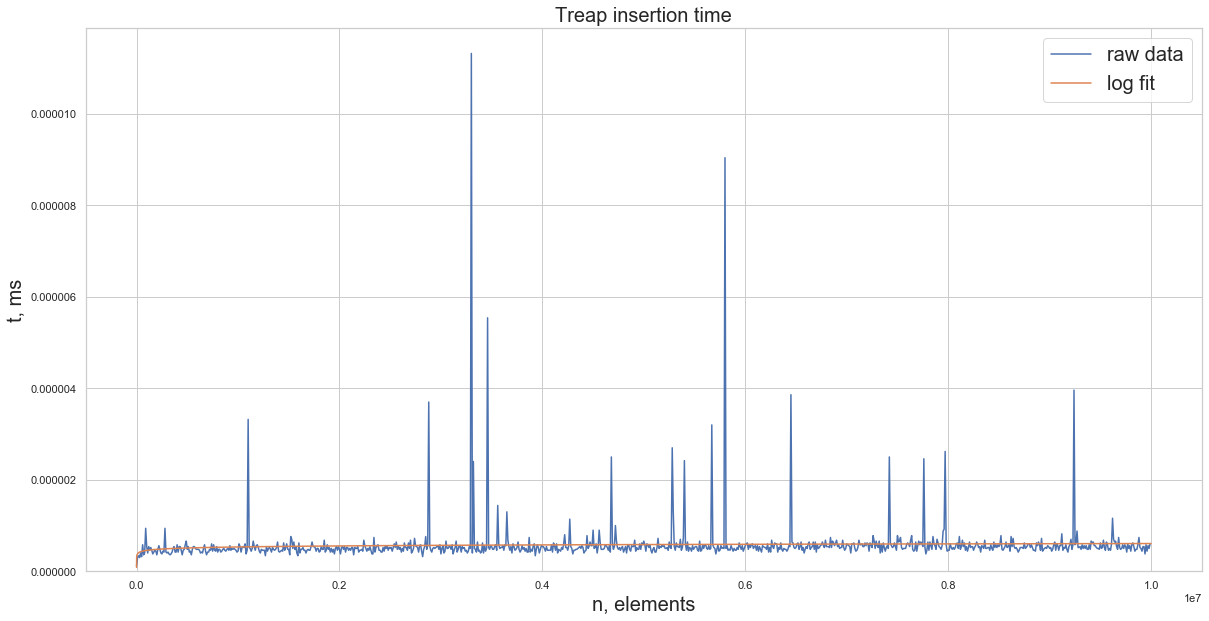

In [34]:
y = [insert_time[el] for el in x]

plt.title("Treap insertion time", fontsize=20)
plt.xlabel('n, elements', fontsize=20)
plt.ylabel('t, ms', fontsize=20)
plt.plot(x, y)

# Least Squares log Regression
coeff = np.polyfit(np.log2(num), insert_time, 1)
log_y = [np.log2(n)*coeff[0] + coeff[1] for n in num]
plt.plot(num, log_y)  
plt.legend(['raw data', 'log fit'], fontsize=20)
plt.ylim(bottom=0.)
pass

### Searching

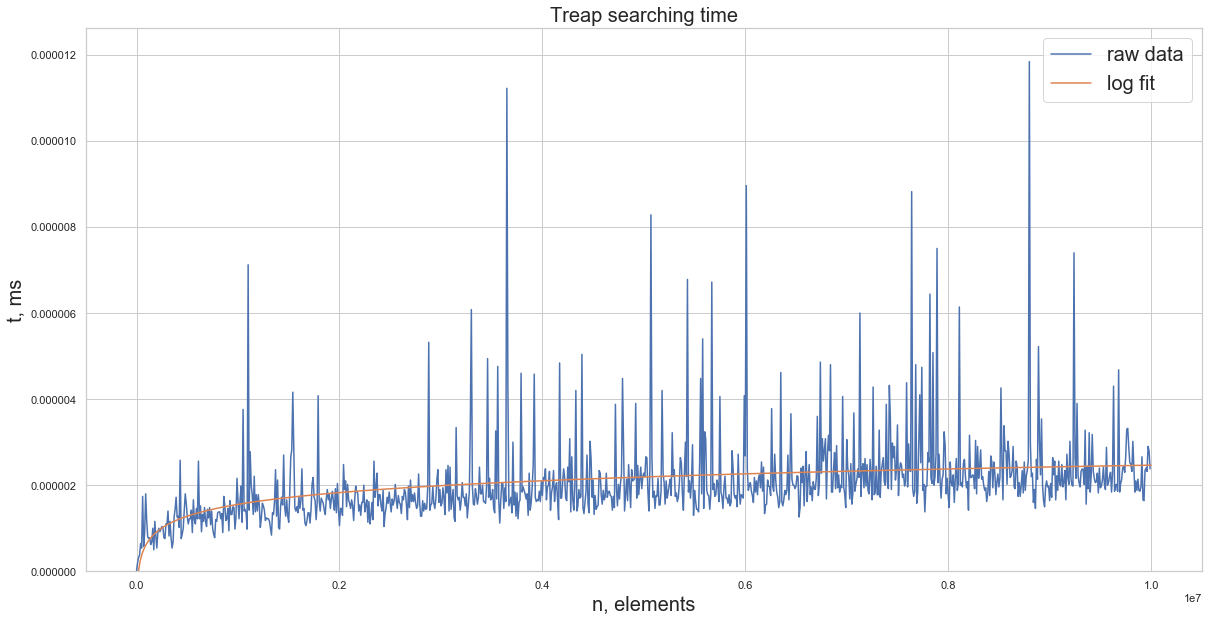

In [36]:
y = [search_time[el] for el in x]

plt.title("Treap searching time", fontsize=20)
plt.xlabel('n, elements', fontsize=20)
plt.ylabel('t, ms', fontsize=20)
plt.plot(x, y)

# Least Squares log Regression
coeff = np.polyfit(np.log2(num), search_time, 1)
log_y = [np.log2(n)*coeff[0] + coeff[1] for n in num]
plt.plot(num, log_y)  
plt.legend(['raw data', 'log fit'], fontsize=20)
plt.ylim(bottom=0.)
pass

### Deletion

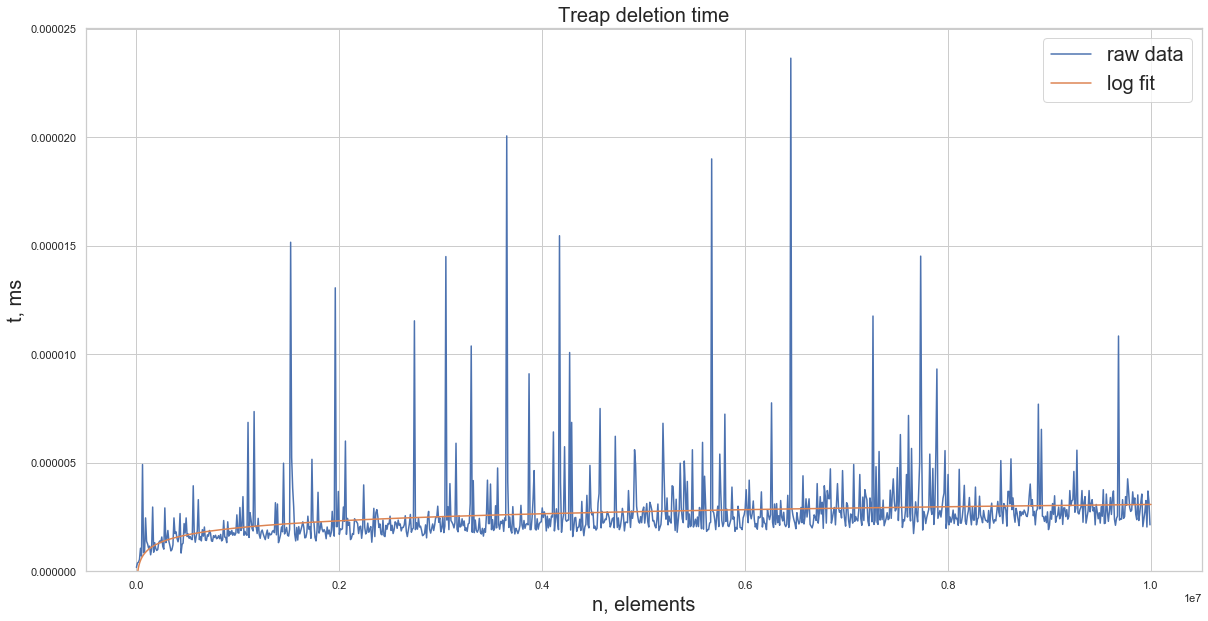

In [38]:
y = [delete_time[el] for el in x]

plt.title("Treap deletion time", fontsize=20)
plt.xlabel('n, elements', fontsize=20)
plt.ylabel('t, ms', fontsize=20)
plt.plot(x, y)

# Least Squares log Regression
coeff = np.polyfit(np.log2(num), delete_time, 1)
log_y = [np.log2(n)*coeff[0] + coeff[1] for n in num]
plt.plot(num, log_y)  
plt.legend(['raw data', 'log fit'], fontsize=20)
plt.ylim(bottom=0.)
pass

# Red-Black tree

Один из видов самобалансирующихся двоичных деревьев поиска, гарантирующих логарифмический рост высоты дерева от числа узлов и позволяющее быстро выполнять основные операции дерева поиска: добавление, удаление и поиск узла. Сбалансированность достигается за счёт введения дополнительного атрибута узла дерева — «цвета». Этот атрибут может принимать одно из двух возможных значений — «чёрный» или «красный». 

Для реализации используется std::set<T> из стандартной библиотеки cpp. Основные операции в среднем выполняются за O(log(n)).

In [7]:
insert_time, search_time, delete_time, _ = evaluate(trees.RBTreeInt(), unique_num_set)

Insert, Mean : 0.000363 ms.,  Max 1.753580 ms.
Search, Mean : 0.001835 ms.,  Max 2.420100 ms.
Delete, Mean : 0.002502 ms.,  Max 3.440100 ms.
Total time 430.498830, sec


### Insertion

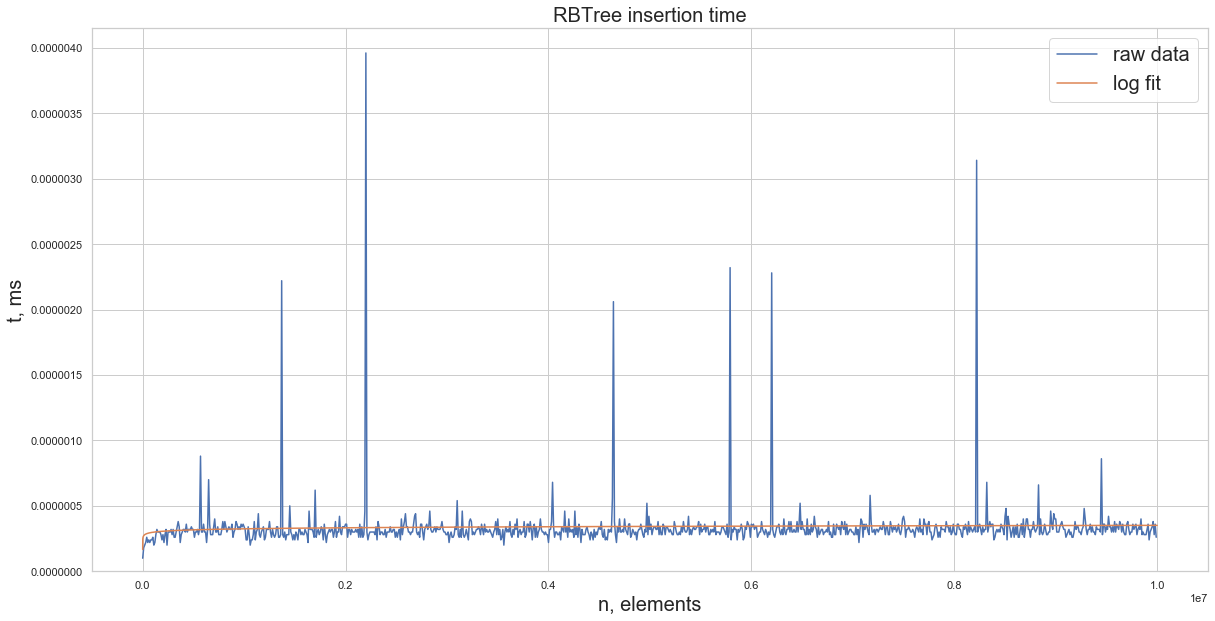

In [16]:
y = [insert_time[el] for el in x]

plt.title("RBTree insertion time", fontsize=20)
plt.xlabel('n, elements', fontsize=20)
plt.ylabel('t, ms', fontsize=20)
plt.plot(x, y)

# Least Squares log Regression
coeff = np.polyfit(np.log2(num), insert_time, 1)
log_y = [np.log2(n)*coeff[0] + coeff[1] for n in num]
plt.plot(num, log_y)  
plt.legend(['raw data', 'log fit'], fontsize=20)
plt.ylim(bottom=0.)
pass

### Searching

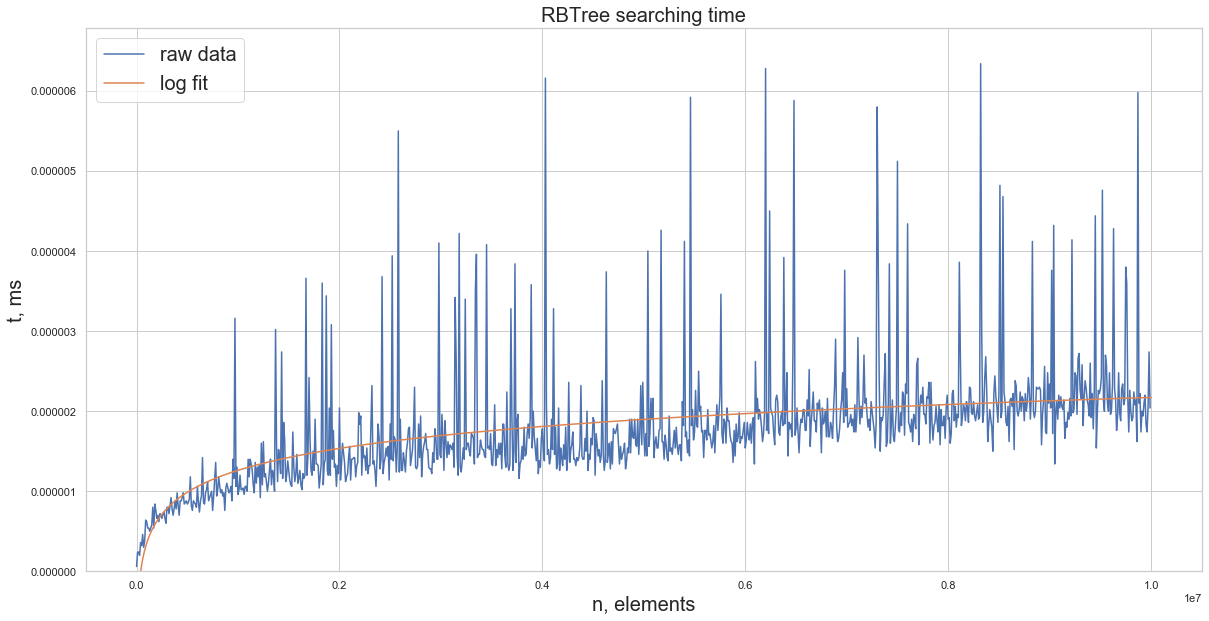

In [18]:
y = [search_time[el] for el in x]

plt.title("RBTree searching time", fontsize=20)
plt.xlabel('n, elements', fontsize=20)
plt.ylabel('t, ms', fontsize=20)
plt.plot(x, y)

# Least Squares log Regression
coeff = np.polyfit(np.log2(num), search_time, 1)
log_y = [np.log2(n)*coeff[0] + coeff[1] for n in num]
plt.plot(num[50:], log_y[50:])  
plt.legend(['raw data', 'log fit'], fontsize=20)
plt.ylim(bottom=0.)
pass

### Deletion

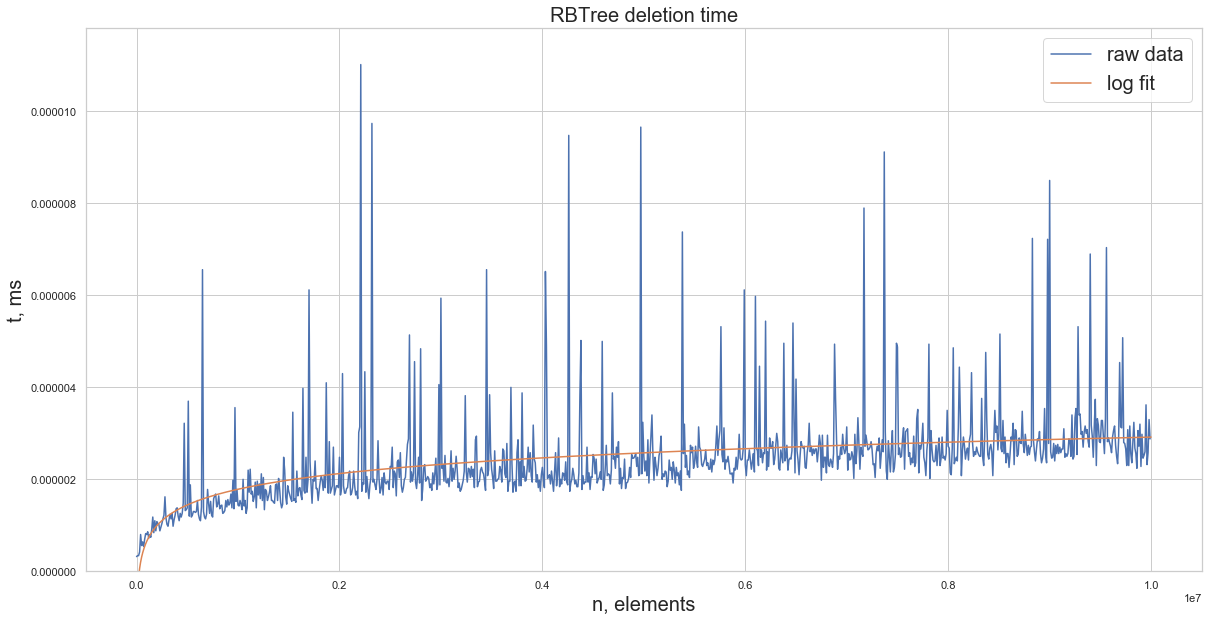

In [20]:
y = [delete_time[el] for el in x]

plt.title("RBTree deletion time", fontsize=20)
plt.xlabel('n, elements', fontsize=20)
plt.ylabel('t, ms', fontsize=20)
plt.plot(x, y)


# Least Squares log Regression
coeff = np.polyfit(np.log2(num), delete_time, 1)
log_y = [np.log2(n)*coeff[0] + coeff[1] for n in num]
plt.plot(num, log_y)  
plt.legend(['raw data', 'log fit'], fontsize=20)
plt.ylim(bottom=0.)
pass

# Sorted array

Отсортированныый массив. 

Среднее время вставки O(n) - при каждой вставке не в конец массива приходится его перепаковывать. Возможна реаллокация массива, если при очередной вставке размер превысит ёмкость

Среднее время удаления O(n) - при каждом удалении не из конца массива, его также приходится перепаковывать.

Среднее время поиска O(log(n)) - при реализации бинарного поиска.

Для 10^7 элементов оценивание времён вставки, удаления и поиска для отсортированного массива проходит слишком долго, поэтому оценивание будет производиться на 10^6 элементах.

In [39]:
r = 10**6
unique_num_set = random.sample(range(0, r), r)
num = range(1, len(unique_num_set))
d = 10**4
x = [i*d for i in range(len(unique_num_set)//d)]
x[-1] += -1

In [ ]:
insert_time, search_time, delete_time, _ = evaluate(trees.SortedArrInt(), unique_num_set)

### Insertion

In [ ]:
y = [insert_time[el] for el in x]

plt.title("Sorted array insertion time", fontsize=20)
plt.xlabel('n, elements', fontsize=20)
plt.ylabel('t, ms', fontsize=20)
plt.plot(x, y)

# Least Squares log Regression
coeff = np.polyfit(num, insert_time, 1)
lin_y = [n*coeff[0] + coeff[1] for n in num]
plt.plot(num, lin_y)  
plt.legend(['raw data', 'log fit'], fontsize=20)
plt.ylim(bottom=0.)
pass

### Searching

In [ ]:
y = [search_time[el] for el in x]

plt.title("Sorted array searching time", fontsize=20)
plt.xlabel('n, elements', fontsize=20)
plt.ylabel('t, ms', fontsize=20)
plt.plot(x, y)

# Least Squares log Regression
coeff = np.polyfit(np.log2(num), search_time, 1)
lin_y = [np.log2(n)*coeff[0] + coeff[1] for n in num]
plt.plot(num, lin_y)  
plt.legend(['raw data', 'log fit'], fontsize=20)
plt.ylim(bottom=0.)
pass

### Deletion

In [ ]:
y = [delete_time[el] for el in x]
plt.title("Sorted array deletion time", fontsize=20)
plt.xlabel('n, elements', fontsize=20)
plt.ylabel('t, ms', fontsize=20)
plt.plot(x, y)

# Least Squares log Regression
coeff = np.polyfit(num, delete_time, 1)
lin_y = [n*coeff[0] + coeff[1] for n in num]
plt.plot(num, lin_y)  
plt.legend(['raw data', 'log fit'], fontsize=20)
plt.ylim(bottom=0.)
pass